In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
def get_precisions_recalls(actual, preds):
    plt.figure(figsize=(16,4))
    
    plt.subplot(1,2,1)
    precision_0 = np.sum((actual == 0) & (preds == 0)) / np.sum(preds == 0)
    precision_1 = np.sum((actual == 1) & (preds == 1)) / np.sum(preds == 1)
    
    plt.bar([0,1], [precision_0, precision_1])
    plt.xticks([0,1], ['Class 0', 'Class 1'], fontsize=20)
    plt.yticks(np.arange(0,1.1,0.1), fontsize=14)
    plt.ylabel('Precision', fontsize=20)
    plt.title(f'Precision Class 0: {round(precision_0,2)}\nPrecision Class 1: {round(precision_1,2)}', fontsize=20)
    
    plt.subplot(1,2,2)
    recall_0 = np.sum((actual == 0) & (preds == 0)) / np.sum(actual == 0)
    recall_1 = np.sum((actual == 1) & (preds == 1)) / np.sum(actual == 1)
    
    plt.bar([0,1], [recall_0, recall_1])
    plt.xticks([0,1], ['Class 0', 'Class 1'], fontsize=20)
    plt.yticks(np.arange(0,1.1,0.1), fontsize=14)
    plt.ylabel('Recall', fontsize=20)
    plt.title(f'Recall Class 0: {round(recall_0,2)}\nRecall Class 1: {round(recall_1,2)}', fontsize=20)
    
    plt.tight_layout()
    plt.show()

# Generate/Read Data

In [27]:
mode = 'read'

In [28]:
np.random.seed(314159)

In [29]:
def generate_data(n, k, weights, cutoff):
    X = np.random.random((n, k))
    labels = (X@weights < cutoff*np.mean(X@weights)).astype(int)
    return X,labels.flatten()

In [30]:
def read_data():
    df = pd.read_csv('diabetes.csv')
    df = df.sample(frac=1).reset_index(drop=True)
    df_train = df.iloc[:len(df)//2]
    df_test = df.iloc[len(df)//2:]
    X_train = df_train[[c for c in df.columns if c != 'Outcome']].values
    labels_train = df_train.Outcome.values
    X_test = df_test[[c for c in df.columns if c != 'Outcome']].values
    labels_test = df_test.Outcome.values
    return X_train, labels_train, X_test, labels_test

In [31]:
n_train = 10000
n_test = 10000
k = 10
cutoff = 0.5
weights = np.random.random((k,1))

In [32]:
if mode == 'generate':
    X_train, labels_train = generate_data(n_train, k, weights, cutoff)
    X_test, labels_test = generate_data(n_test, k, weights, cutoff)
elif mode == 'read':
    X_train, labels_train, X_test, labels_test = read_data()

In [33]:
print('Fraction of positive labels:', str(round(100*np.mean(labels_train),3)) + '%')

Fraction of positive labels: 36.458%


# Train Decision Tree

In [34]:
clf = DecisionTreeClassifier()
clf.fit(X_train, labels_train)
preds = clf.predict(X_test)

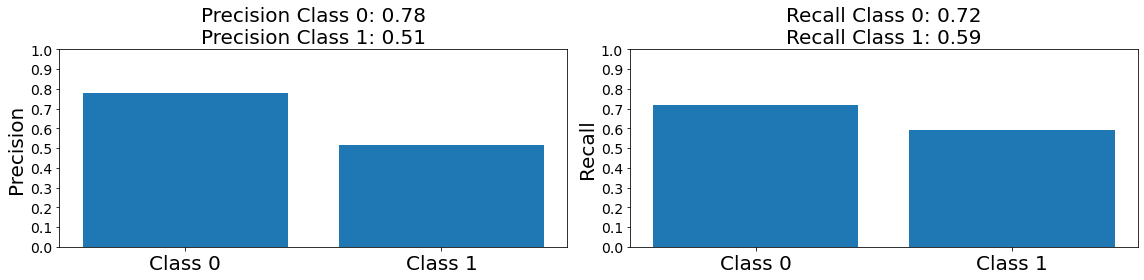

In [35]:
get_precisions_recalls(labels_test, preds)

# Solution 1: Upweight the Minority Class

In [36]:
weight_minority_class = np.sum(labels_train == 0) / np.sum(labels_train == 1)

In [37]:
weight_minority_class

1.7428571428571429

In [38]:
clf = DecisionTreeClassifier(class_weight={0:1, 1:weight_minority_class})
clf.fit(X_train, labels_train)
preds = clf.predict(X_test)

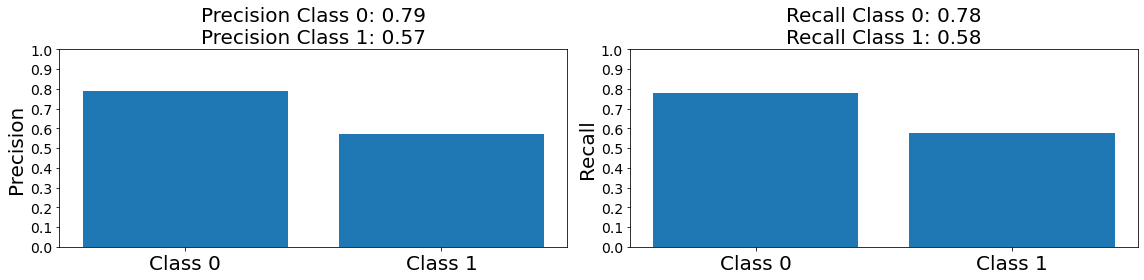

In [39]:
get_precisions_recalls(labels_test, preds)

# Solution 2: Oversample Minority Class

In [40]:
#get indices of each class
indices_0 = np.where(labels_train == 0)[0]
indices_1 = np.where(labels_train == 1)[0]
indices = np.concatenate([indices_0, indices_1])

#get weights for each class
weights = np.empty(indices_0.shape[0] + indices_1.shape[0])
weights[:indices_0.shape[0]] = 1
weights[indices_0.shape[0]:] = weight_minority_class
weights = weights/np.sum(weights)

#sample new indices
sampled_indices = np.random.choice(indices, indices.shape[0], p=weights)

In [41]:
#consruct oversampled datasets
X_train_oversampled = X_train[sampled_indices]
labels_train_oversampled = labels_train[sampled_indices]

In [42]:
print('Fraction of positive labels in oversampled data:', str(round(100*np.mean(labels_train_oversampled),3)) + '%')

Fraction of positive labels in oversampled data: 50.26%


In [43]:
clf = DecisionTreeClassifier()
clf.fit(X_train_oversampled, labels_train_oversampled)
preds = clf.predict(X_test)

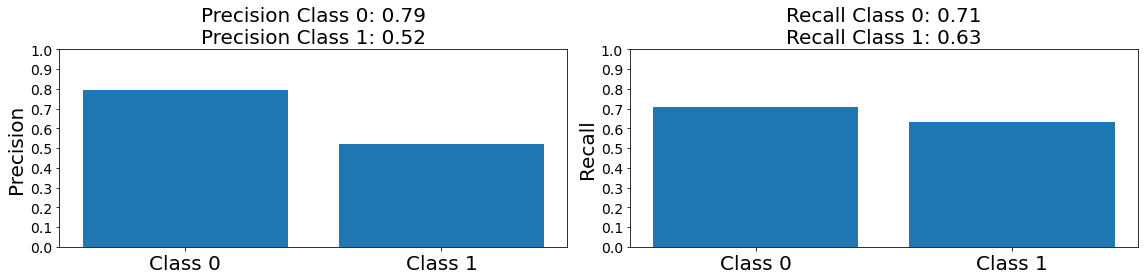

In [44]:
get_precisions_recalls(labels_test, preds)

# Solution 2a: SMOTE (Synthetic Minority Oversampling TEchnique)

In [45]:
#populate entire dataset
X_train_oversampled_smote = []
labels_train_oversampled_smote = []

for _ in range(X_train.shape[0]):
    p = np.random.random()
    #sample from majority class
    if p < 0.5:
        X_train_oversampled_smote.append(X_train[np.random.choice(indices_0)])
        labels_train_oversampled_smote.append(0)
    #sample from minority class
    else:
        #get two random samples from minority class
        minority_samp_1 = X_train[np.random.choice(indices_1)]
        minority_samp_2 = X_train[np.random.choice(indices_1)]
        
        #get random proportion with which to mix them
        prop = np.random.random()
        
        #generate synthetic sample from minority class
        synthetic_minority_samp = prop*minority_samp_1 + (1-prop)*minority_samp_2
        X_train_oversampled_smote.append(synthetic_minority_samp)
        labels_train_oversampled_smote.append(1)
        
X_train_oversampled_smote = np.array(X_train_oversampled_smote)
labels_train_oversampled_smote = np.array(labels_train_oversampled_smote)

In [46]:
print('Fraction of positive labels in SMOTE oversampled data:', str(round(100*np.mean(labels_train_oversampled_smote),3)) + '%')

Fraction of positive labels in SMOTE oversampled data: 51.823%


In [47]:
unique_naive_oversample = np.unique(X_train_oversampled[labels_train_oversampled == 1], axis=0).shape[0]
unique_smote_oversample = np.unique(X_train_oversampled_smote[labels_train_oversampled_smote == 1], axis=0).shape[0]

print('Num Unique Class=1 Feature Vectors with Naive Oversample:', unique_naive_oversample)
print('Num Unique Class=1 Feature Vectors with SMOTE Oversample:', unique_smote_oversample)

Num Unique Class=1 Feature Vectors with Naive Oversample: 104
Num Unique Class=1 Feature Vectors with SMOTE Oversample: 199


In [48]:
clf = DecisionTreeClassifier()
clf.fit(X_train_oversampled_smote, labels_train_oversampled_smote)
preds = clf.predict(X_test)

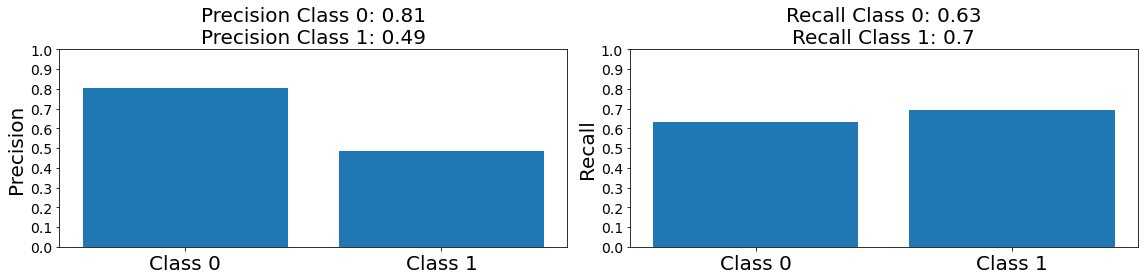

In [49]:
get_precisions_recalls(labels_test, preds)